In [319]:
import torch.nn as nn
import torch

class LSTM_VAE(nn.Module):
    def __init__(self, z_dim, T, x_dim, lstm_units, batch_size=1):
        super(LSTM_VAE, self).__init__()

        self.z_dim = z_dim
        self.T = T
        self.x_dim = x_dim
        self.lstm_units = lstm_units
        self.batch_size = batch_size
        
        # Everything going on in the network has to be of size:
        # (batch_size, T, n_features)
        
        # We encode the data onto the latent space using bi-directional LSTM
        self.encoder = nn.LSTM(
            input_size=self.x_dim,
            hidden_size=self.lstm_units,
            num_layers=1,
            bias=True,
            batch_first=True,
            dropout=0,
            bidirectional=True
        )
        
        self.fnn_zmu = nn.Linear(
            in_features=2*self.lstm_units,
            out_features=self.z_dim,
            bias=True
        )

        self.fnn_zvar = nn.Linear(
            in_features=2*self.lstm_units,
            out_features=self.z_dim,
            bias=True
        )
        
        self.fnn_cmu = nn.Linear(
            in_features=2*self.lstm_units,
            out_features=self.z_dim,
            bias=True
        )
        
        self.fnn_cvar = nn.Linear(
            in_features=2*self.lstm_units,
            out_features=self.z_dim,
            bias=True
        )
        
        # The latent code must be decoded into the original image
        self.decoder = nn.LSTM(
            input_size=self.z_dim*2,
            hidden_size=self.lstm_units,
            num_layers=1,
            bias=True,
            batch_first=True,
            dropout=0,
            bidirectional=True
        )
        
        self.fnn_xmu = nn.Linear(
            in_features=2*self.lstm_units,
            out_features=self.x_dim,
            bias=True
        )
        
        self.fnn_xb = nn.Linear(
            in_features=2*self.lstm_units,
            out_features=self.x_dim,
            bias=True
        ) 

        # Initialize hidden state and cell state as learnable parameters
        self.hidden_state = torch.zeros(2, 1, self.lstm_units)
        self.cell_state = torch.zeros(2, 1, self.lstm_units)

        
    def forward(self, x):
        outputs = {}
        
        out_encoded, (hidden_encoded, cell_encoded) = self.encoder(x, (self.hidden_state, self.cell_state))
        flat_hidden = hidden_encoded.reshape(1, 1, 2*self.lstm_units)
        
        # Fully connected layer from LSTM to var and mu
        mu_z = self.fnn_zmu(flat_hidden)
        sigma_z = nn.functional.softplus(self.fnn_zvar(flat_hidden))

        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)

        # Don't propagate gradients through randomness
        with torch.no_grad():
            epsilon_z = torch.randn(
                self.batch_size, self.T, self.z_dim)

        # (batch_size, latent_dim) -> (batch_size, 1, latent_dim)
        z = mu_z + epsilon_z * sigma_z        

        # Here goes the Variational Self-Attention Network 
        
        # Calculate the similarity matrix
        S = torch.zeros(self.batch_size, self.T, self.T)
        for b in range(self.batch_size):
            for i in range(self.T):
                for j in range(i+1, self.T):
                    S[b,i,j] = torch.dot(out_encoded[b,i,:], out_encoded[b,j,:])
                    S[b,j,i] = S[b,i,j]
        
        # Use softmax to get the sum of weights to equal 1
        A = nn.functional.softmax(S, dim=1)
        
        Cdet = torch.zeros(self.batch_size, self.T, 2*self.lstm_units)
        
        for b in range(self.batch_size):
            for t in range(self.T):
                Cdet[b,t,:] = torch.matmul(A[b,:,t], out_encoded[b])
        
        # Fully connected layer from LSTM to var and mu
        mu_c = self.fnn_cmu(Cdet)
        sigma_c = nn.functional.softplus(self.fnn_cvar(Cdet))

        # Don't propagate gradients through randomness
        with torch.no_grad():
            epsilon_c = torch.randn(
                self.batch_size, self.T, self.z_dim)

        c = mu_c + epsilon_c * sigma_c     
        
        # Concatenate z and c before giving it as input to the decoder
        encoded = torch.cat((z,c), dim=2)
        
        # Run through decoder
        out_decoded, _ = self.decoder(encoded)
        
        # Pass the decoder outputs through fnn to get LaPlace parameters
        mu_x = self.fnn_xmu(out_decoded)
        b_x = nn.functional.softplus(self.fnn_xb(out_decoded))
        
        outputs["z"] = z
        outputs["mu_z"] = mu_z
        outputs["sigma_z"] = sigma_z
        outputs["c"] = c
        outputs["mu_c"] = mu_c
        outputs["sigma_c"] = sigma_c
        outputs["mu_x"] = mu_x
        outputs["b_x"] = b_x
        
        
        return outputs


In [320]:
from lstmAD.dataload.load_data import load_data

train, _ = load_data('ItalyPowerDemand', basepath='..')

train_x = torch.Tensor(train[:2, 20]).unsqueeze(1).unsqueeze(0)

print(train_x.shape)


torch.Size([1, 2, 1])


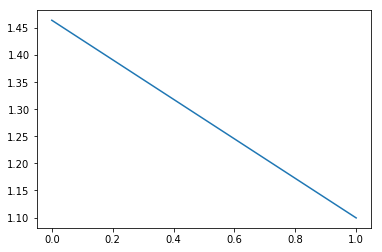

In [321]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(train_x[0,:].numpy())

In [322]:
z_dim = 3
N = train_x.shape[0]
T = train_x.shape[1]
x_dim = train_x.shape[2]
lstm_units = 128

net = LSTM_VAE(z_dim, T, x_dim, lstm_units)

output = net(train_x)

#print(output['x_hat'][0].shape)

In [323]:
# Concatenated final hidden state:
print(output['hidden'].shape)

KeyError: 'hidden'

In [313]:
# Concatenated hidden state (but how it is concatenated??)
out = net.encoder(train_x, (torch.zeros(2, 1, 128), torch.zeros(2, 1, 128)))[0]
print(out.shape)

# Final hidden state (forward+backward, batch, num_lstm_units)
hidden = net.encoder(train_x, (torch.zeros(2, 1, 128), torch.zeros(2, 1, 128)))[1][0]
print(hidden.shape)

# Final cell state (forward+backward, batch, num_lstm_units)
cell = net.encoder(train_x, (torch.zeros(2, 1, 128), torch.zeros(2, 1, 128)))[1][1]
print(cell.shape)

torch.Size([1, 2, 256])
torch.Size([2, 1, 128])
torch.Size([2, 1, 128])


In [308]:
output

{'hidden': tensor([[[-0.0283, -0.0386,  0.0142,  0.0074,  0.0524, -0.0074, -0.0226,
           -0.0064, -0.0065,  0.0444,  0.0250,  0.0268,  0.0009, -0.0128,
            0.0014, -0.0167, -0.0343, -0.0041, -0.0041,  0.0115,  0.0046,
            0.0104,  0.0412, -0.0349,  0.0402, -0.0157,  0.0413,  0.0408,
           -0.0084, -0.0230, -0.0465,  0.0043, -0.0164, -0.0203,  0.0529,
           -0.0185, -0.0007, -0.0075, -0.0323, -0.0255,  0.0405,  0.0177,
           -0.0084,  0.0298,  0.0089,  0.0150,  0.0264, -0.0145,  0.0238,
            0.0241,  0.0051, -0.0074, -0.0349, -0.0236, -0.0061, -0.0119,
           -0.0294, -0.0132,  0.0212, -0.0365, -0.0165,  0.0052,  0.0330,
           -0.0198, -0.0061,  0.0220, -0.0153, -0.0004, -0.0258, -0.0198,
           -0.0100, -0.0235, -0.0082, -0.0291, -0.0157, -0.0008,  0.0005,
           -0.0149, -0.0062, -0.0413, -0.0266,  0.0227,  0.0260, -0.0138,
            0.0187, -0.0500,  0.0085,  0.0112, -0.0367,  0.0072,  0.0160,
            0.0163,  0.0103,